# Tracking Multiple Particles with a U-net

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS131_tracking_multiple_particles_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the (pseudo)probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 1. Defining the Particle

For this example, you consider point particles (point light scatterers). A point particle is an instance of the `PointParticle` class, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [DTGS121_tracking_particle_cnn](DTGS121_tracking_particle_cnn.ipynb).

In [3]:
particle = dt.PointParticle(
    intensity=100,
    position=lambda: np.random.rand(2) * 256,
)

## 2. Defining the Optical System

Next, you need to define the properties of the optical system. This is done using an instance of the `Fluorescence` class, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [DTGS121_tracking_particle_cnn](DTGS121_tracking_particle_cnn.ipynb).

In [4]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.7,
    resolution=1e-6,
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 3. Defining Noises

You will introduce two sources of noise (see also [DTAT327_noises](../3-advanced-topics/DTAT327_noises.ipynb)):

1. A background random offset between 0 and 1.

2. A Poisson noise with a random SNR between 3 and 10.

In [5]:
offset = dt.Add(
    value=lambda: np.random.rand() * 1
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand() * 7 + 3,
    background=offset.value
)

## 4. Defining the Image Features

You want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [8]:
num_particles = lambda: np.random.randint(1, 11)

image_features = (
    fluorescence_microscope(particle ^ num_particles)
    >> offset
    >> poisson_noise
)

## 5. Plotting Some Example Images

Now, you can visualize some example images. At each iteration, call the method `.update()` to refresh the random features in the image (particle number, particle positions, offset level, and Poisson noise). Afterwards, call the method `.plot()` to generate and display the image.

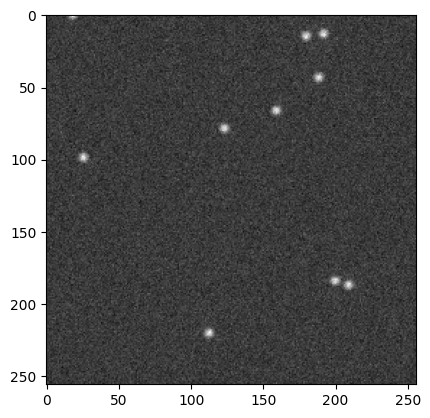

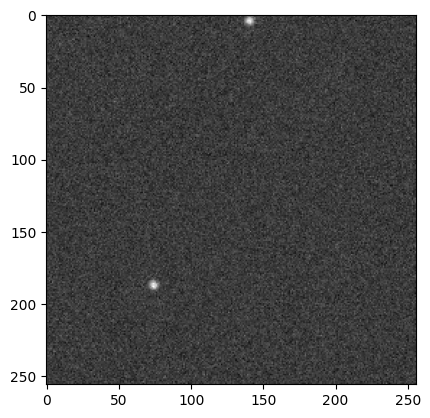

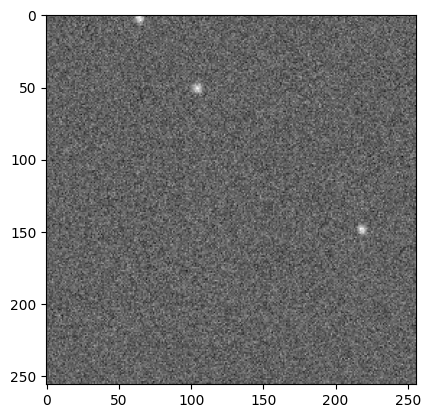

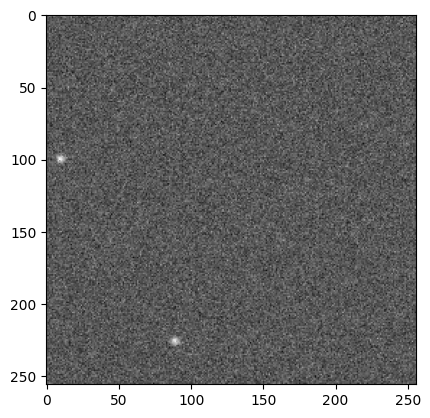

In [ ]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")
    plt.show()

## 6. Creating the Target Images

You now need to define a function that uses the generated images to create the target images to be used in the training. Here, the target image is a binary image, where each pixel is `1` if it is within `CIRCLE_RADIUS` distance from any particle in the input image, and 0 otherwise.

In [14]:
image_features.store_properties()  # Store the properties of the particles.

circle_radius = 3

def get_target_image(image_of_particles):
    """Create a binary image with the circles in the particle positions. """
    
    target_image = np.zeros(image_of_particles.shape)
    x, y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]),
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]

            distance_map = (x - position[1]) ** 2 + (y - position[0]) ** 2
            target_image[distance_map < circle_radius ** 2] = 1

    return target_image

You can now plot images and targets side by side.

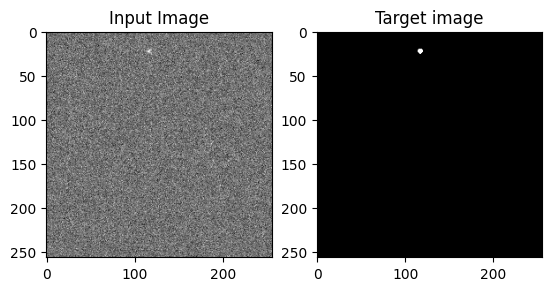

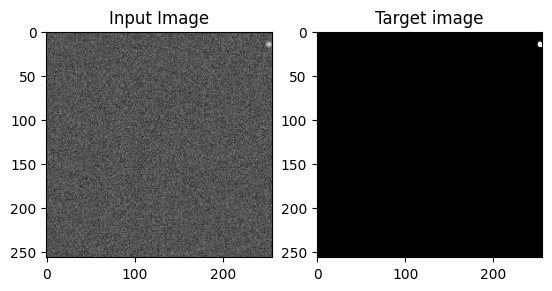

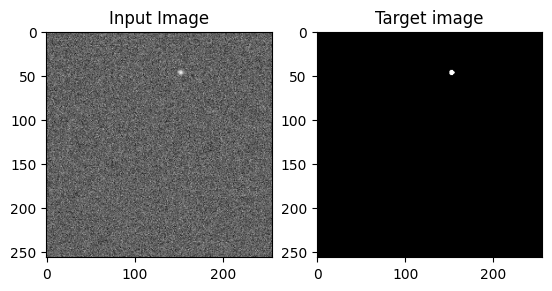

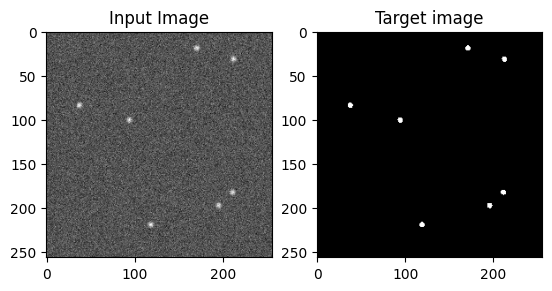

In [15]:
for i in range(4):

    image_features.update()
    image_of_particles = image_features.resolve()

    target_image = get_target_image(image_of_particles)

    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(image_of_particles), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(target_image), cmap="gray")
    plt.title("Target image")

    plt.show()

## 8. Defining the Neural Network Model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations.

Since the desired output is a binary image, you will use crossentropy as the loss function. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), you need to weight the loss such that false negatives are penalized ten times more than the false positives.

The model can be customized by passing the following arguments:

- `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

- `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down- and upsampling.
    
- `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base of the unet, where the image is the most downsampled.

- `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the upsampling.
    
- `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling step.

- `number_of_outputs`: Number of convolutions in output layer.

- `output_activation`: The activation function of the output.

- `loss`: The loss function of the network.

- `optimizer`: The the optimizer used for training.

- `metrics`: Additional metrics to evaulate during training.

In [16]:
import deeptrack.deeplay as dl
import torchmetrics as tm

data_pipeline = image_features & (image_features >> get_target_image)

net = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)

weight = dl.torch.tensor([500])
model = dl.Regressor(
    net,
    loss=dl.torch.nn.BCEWithLogitsLoss(pos_weight=weight),
    optimizer=dl.optimizers.Adam(lr=1e-4),
    metrics=[tm.F1Score(task="binary")],
)

## 9. Training the Model

The model is trained by calling `.fit()`. This will take a few minutes.

In [18]:
h = model.fit(
    train_data=data_pipeline,
    val_data=data_pipeline,
    max_epochs=100,
    steps_per_epoch=25,
    val_steps_per_epoch=5,
    accelerator="auto",
)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCEWithLogitsLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection  │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection  │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection  │      0 │ train │
│ 4 │ model         │ UNet2d            │  128 K │ train │
│ 5 │ optimizer     │ Adam              │      0 │ train │
└───┴───────────────┴───────────────────┴────────┴───────┘

Trainable params: 128 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 128 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

You can now plot the training history.

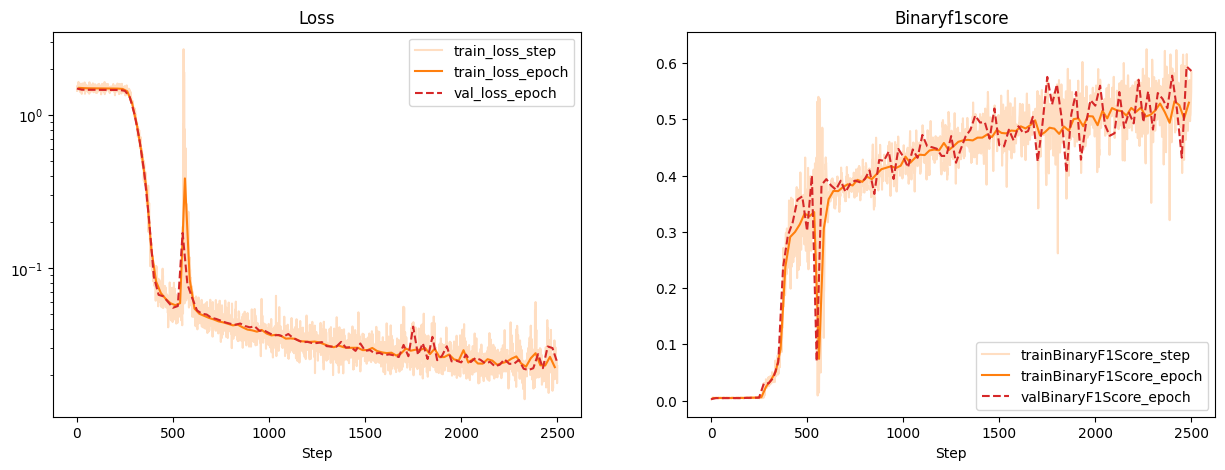

In [19]:
fig, ax = h.plot()
ax[0].set_yscale("log")
ax[1].set_yscale("linear")

## 10. Visualizing the Model Performance

Finally, you can evaluate the model performance by showing the model output besides the input image and the target image.

584.1428571428571


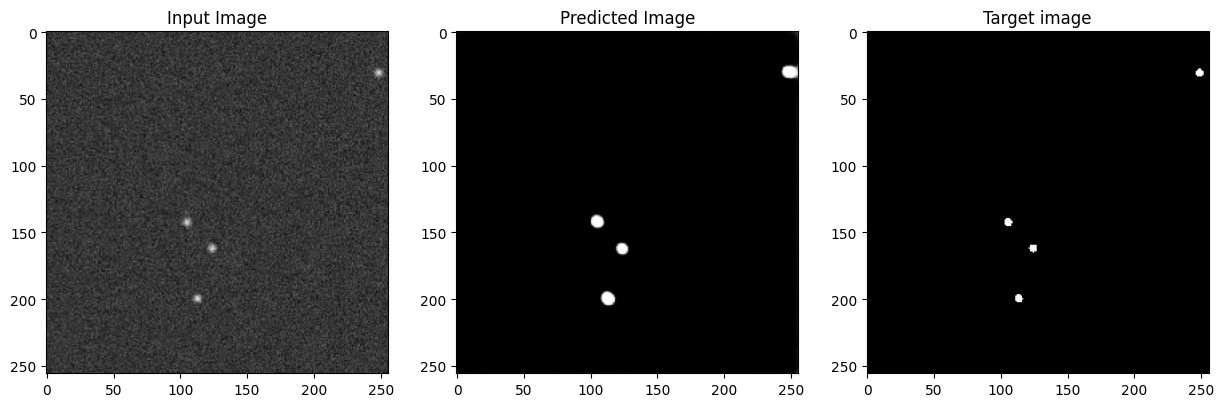

260.0996015936255


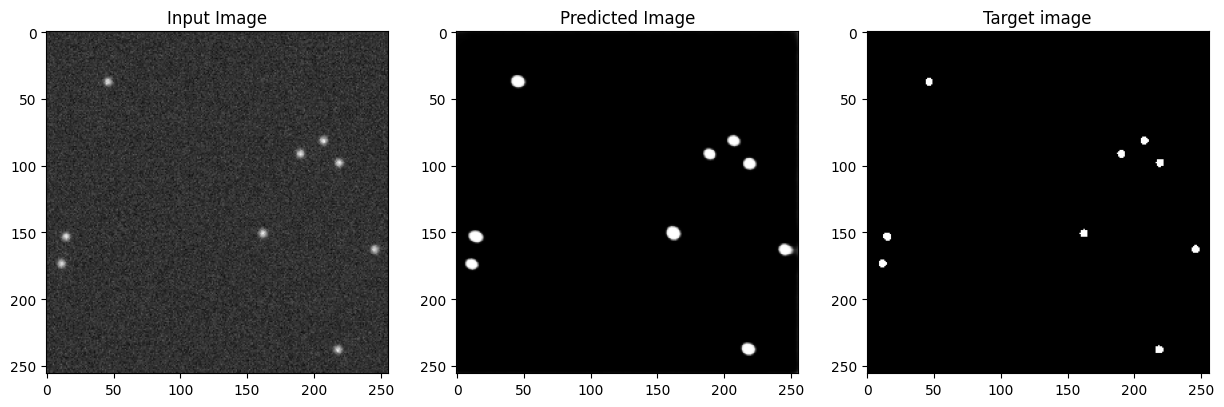

839.2051282051282


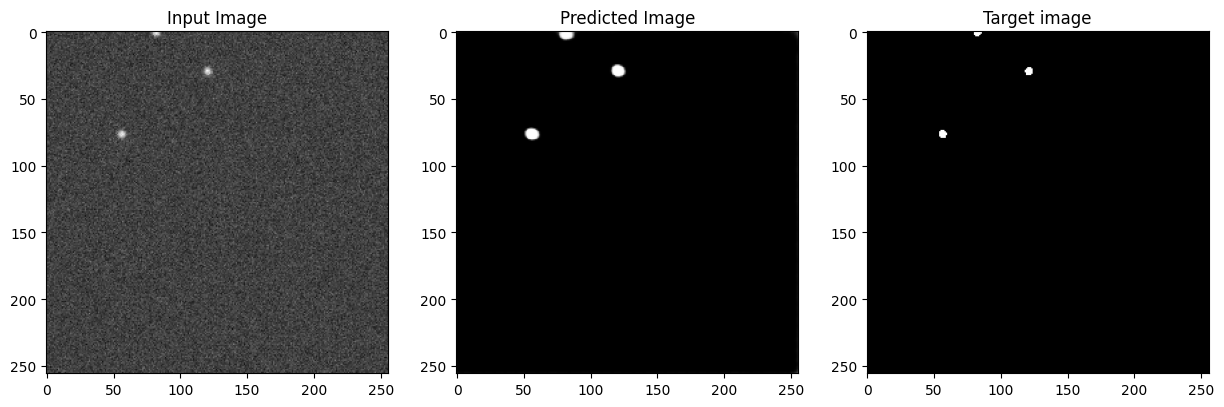

382.2514619883041


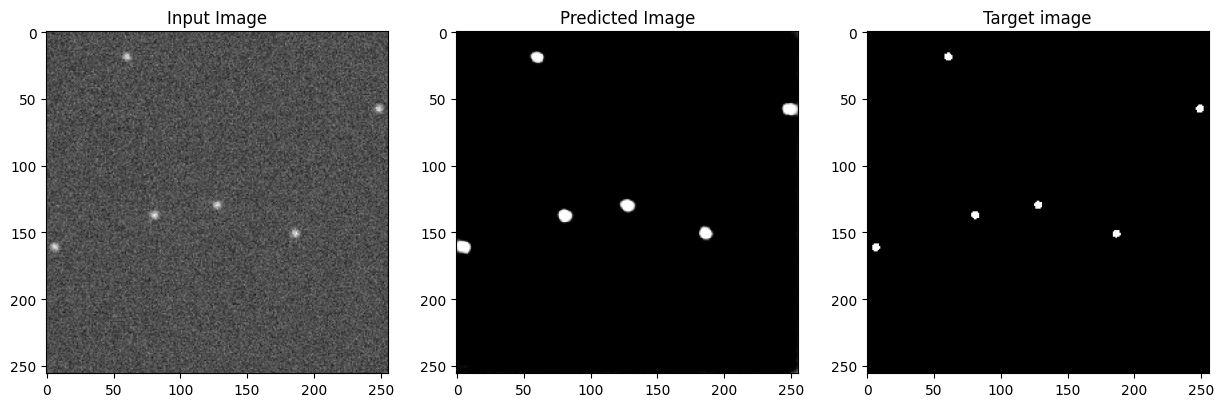

In [20]:
images, targets = data_pipeline.batch(4)
predicted_probabilities = \
    model.predict(np.transpose(images,(0,3,2,1)).astype(np.float32)).sigmoid()

for i in range(4):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,3,1)
    plt.imshow(images[i, ..., 0].squeeze(), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(predicted_probabilities[i, 0, ...].T, cmap="gray")
    plt.title("Predicted Image")

    plt.subplot(1,3,3)
    plt.imshow(targets[i], cmap="gray")
    plt.title("Target image")
    print((targets[i] == 0).sum() / (targets[i] == 1).sum())

    plt.show()